# Finding vessels that were opening at Fos
## Setup
Install the Signal Ocean SDK:

In [ ]:
!pip install signal-ocean


Set your subscription key, acquired here: [https://apis.signalocean.com/profile](https://apis.signalocean.com/profile)

In [2]:
signal_ocean_api_key = ""  # replace with your subscription key


## Description
In order to perform our analysis, we will query historical tonnage lists for vessel that, in the last 5 days, were opening at Fos and could make it to Ceyhan within a 20-day window:

In [3]:
from datetime import date, timedelta

from signal_ocean import Connection
from signal_ocean.tonnage_list import (
    TonnageListAPI,
    VesselClassFilter,
    PortFilter,
    VesselFilter,
    MarketDeployment,
    CommercialStatus,
    VesselSubclass,
    DateRange,
)

connection = Connection(signal_ocean_api_key)
api = TonnageListAPI(connection)

vessel_class_filter = VesselClassFilter(name_like="aframax")
vessel_class = api.get_vessel_classes(vessel_class_filter)[0]

port_filter = PortFilter(name_like="Ceyhan")
port = api.get_ports(port_filter)[0]

laycan_end_in_days = 20
start_date = date.today() - timedelta(days=5)
end_date = date.today()

vessel_filter = VesselFilter(
    market_deployments=[MarketDeployment.RELET, MarketDeployment.SPOT],
    vessel_subclass=VesselSubclass.DIRTY,
    commercial_statuses=[CommercialStatus.ON_SUBS],
    latest_ais_since=5,
)

htl_for_supply_trend = api.get_historical_tonnage_list(
    port,
    vessel_class,
    laycan_end_in_days,
    DateRange(start_date, end_date),
    vessel_filter=vessel_filter,
)


Now, we can use the data to generate a supply trend for our analysis:

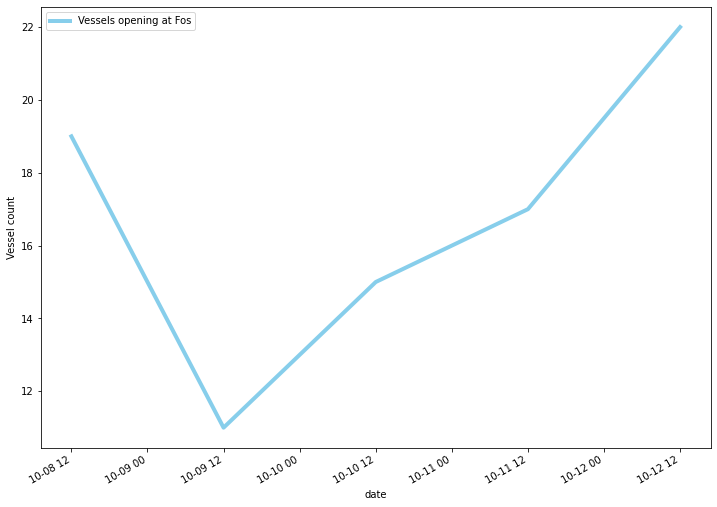

In [4]:
from signal_ocean.tonnage_list import IndexLevel

supply_trend_data_frame = htl_for_supply_trend.to_data_frame()

open_ports_of_interest = ["Fos"]
open_ports_filter = supply_trend_data_frame.open_port_point_in_time.isin(
    open_ports_of_interest
)

aggregated_data = supply_trend_data_frame.groupby(
    IndexLevel.DATE, sort=True
).size()

ax = aggregated_data.plot(
    markerfacecolor="blue",
    color="skyblue",
    linewidth=4,
    label="Vessels opening at Fos",
    figsize=(12, 9),
)

ax.set_ylabel("Vessel count")
ax.legend()
